In [3]:
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage
import sklearn.cluster

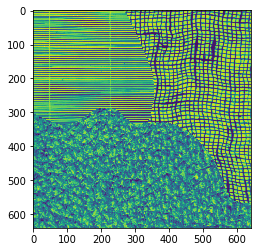

In [4]:
filename = './data/3labels/training_image.png'
I = skimage.io.imread(filename)
I = I.astype(np.float)
plt.imshow(I)

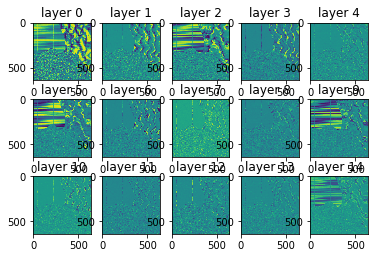

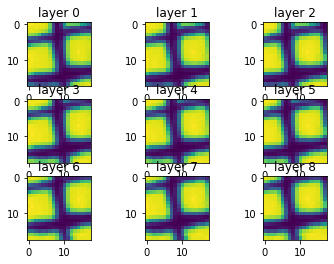

In [5]:
def get_gauss_feat_im(im, sigma=1, normalize=False):
      
    r,c = im.shape
    imfeat = np.zeros((r,c,15))
    imfeat[:,:,0] = scipy.ndimage.gaussian_filter(im,sigma,order=0)
    imfeat[:,:,1] = scipy.ndimage.gaussian_filter(im,sigma,order=[0,1])
    imfeat[:,:,2] = scipy.ndimage.gaussian_filter(im,sigma,order=[1,0])
    imfeat[:,:,3] = scipy.ndimage.gaussian_filter(im,sigma,order=[0,2])
    imfeat[:,:,4] = scipy.ndimage.gaussian_filter(im,sigma,order=[1,1])
    imfeat[:,:,5] = scipy.ndimage.gaussian_filter(im,sigma,order=[2,0])
    imfeat[:,:,6] = scipy.ndimage.gaussian_filter(im,sigma,order=[0,3])
    imfeat[:,:,7] = scipy.ndimage.gaussian_filter(im,sigma,order=[1,2])
    imfeat[:,:,8] = scipy.ndimage.gaussian_filter(im,sigma,order=[2,1])
    imfeat[:,:,9] = scipy.ndimage.gaussian_filter(im,sigma,order=[3,0])
    imfeat[:,:,10] = scipy.ndimage.gaussian_filter(im,sigma,order=[0,4])
    imfeat[:,:,11] = scipy.ndimage.gaussian_filter(im,sigma,order=[1,3])
    imfeat[:,:,12] = scipy.ndimage.gaussian_filter(im,sigma,order=[2,2])
    imfeat[:,:,13] = scipy.ndimage.gaussian_filter(im,sigma,order=[3,1])
    imfeat[:,:,14] = scipy.ndimage.gaussian_filter(im,sigma,order=[4,0])
    
    if normalize:
        imfeat -= np.mean(imfeat, axis=(0,1))
        imfeat *= (1/np.std(imfeat, axis=(0,1)))
    
    return imfeat

def im2col(im, patch_size=[3,3], stepsize=1):
    """Rearrange image patches into columns
    Arguments:
        image: a 2D image, shape (r,c).
        patch size: size of extracted paches.
        stepsize: patch step size.
    Returns:
        patches: a 2D array which in every column has a patch associated 
            with one image pixel. For stepsize 1, number of returned column 
            is (r-patch_size[0]+1)*(c-patch_size[0]+1) due to bounary. The 
            length of columns is pathc_size[0]*patch_size[1].
    """
    
    r,c = im.shape
    s0, s1 = im.strides    
    nrows =r-patch_size[0]+1
    ncols = c-patch_size[1]+1
    shp = patch_size[0],patch_size[1],nrows,ncols
    strd = s0,s1,s0,s1

    out_view = np.lib.stride_tricks.as_strided(im, shape=shp, strides=strd)
    return out_view.reshape(patch_size[0]*patch_size[1],-1)[:,::stepsize]


def ndim2col(im, block_size=[3,3], stepsize=1):
    """Rearrange image blocks into columns for N-D image (e.g. RGB image)"""""
    if(im.ndim == 2):
        return im2col(im, block_size, stepsize)
    else:
        r,c,l = im.shape
        patches = np.zeros((l*block_size[0]*block_size[1],
                            (r-block_size[0]+1)*(c-block_size[1]+1)))
        for i in range(l):
            patches[i*block_size[0]*block_size[1]:(i+1)*block_size[0]*block_size[1],
                    :] = im2col(im[:,:,i],block_size,stepsize)
        return patches

#%%

if __name__ == '__main__':
    
    filename = './data/3labels/training_image.png'
    I = skimage.io.imread(filename)
    I = I.astype(np.float)
    
    
    # features based on gaussian derivatives
    sigma = 1;
    gf = get_gauss_feat_im(I, sigma)
    
    fig,ax = plt.subplots(3,5)
    for j in range(5):
        for i in range(3):
            ax[i][j].imshow(gf[:,:,5*i+j])
            ax[i][j].set_title(f'layer {5*i+j}')
            
            
    # features based on image patches
    I = I[300:320,400:420] # smaller image such that we can see the difference in layers
    pf = im2col(I,[3,3])
    pf = pf.reshape((9,I.shape[0]-2,I.shape[1]-2))
            
    fig,ax = plt.subplots(3,3)
    for j in range(3):
        for i in range(3):
            ax[i][j].imshow(pf[3*i+j])
            ax[i][j].set_title(f'layer {3*i+j}')
            
def ind2labels(ind):
    """ Helper function for transforming uint8 image into labeled image."""
    return np.unique(ind, return_inverse=True)[1].reshape(ind.shape)

Text(0.5, 1.0, 'probabilities for testing image as RGB')

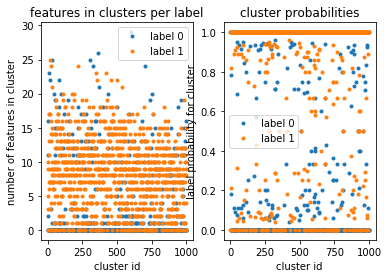

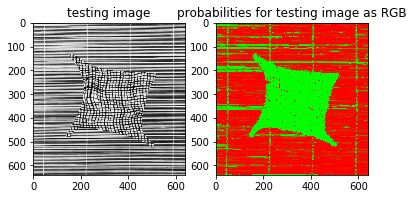

In [129]:
def ind2labels(ind):
    """ Helper function for transforming uint8 image into labeled image."""
    return np.unique(ind, return_inverse=True)[1].reshape(ind.shape)

path = './data/2labels/'

# TRAING THE MODEL
training_image = skimage.io.imread(path + 'training_image.png')
training_image = training_image.astype(np.float)
training_labels = skimage.io.imread(path + 'training_labels.png')

training_labels = ind2labels(training_labels)
nr_labels = np.max(training_labels)+1 # number of labels in the training image

fig, ax = plt.subplots(1,2)
ax[0].imshow(training_image, cmap=plt.cm.gray)
ax[0].set_title('training image')
ax[1].imshow(training_labels)
ax[1].set_title('labels for training image')

#%%
sigma = 2 # standard deviation for gaussian features
features = get_gauss_feat_im(training_image,sigma)
features = features.reshape(-1,features.shape[2])
labels = training_labels.ravel()

nr_keep = 10000 # number of features randomly picked for clustering 
keep_indices = np.random.permutation(np.arange(features.shape[0]))[:nr_keep]

features_subset = features[keep_indices,:]
labels_subset = labels[keep_indices]

nr_clusters = 1000 # number of feature clusters
#kmeans = MiniBatchKMeans(n_clusters=100) # normal k-means, for speed I use mini-batches
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=nr_clusters, batch_size=2*nr_clusters)
kmeans.fit(features_subset)
assignment = kmeans.labels_

edges = np.arange(nr_clusters+1)-0.5 # histogram edges halfway between integers
hist = np.zeros((nr_clusters,nr_labels))
for l in range(nr_labels):
    hist[:,l] = np.histogram(assignment[labels_subset==l],bins=edges)[0]
sum_hist = np.sum(hist,axis=1)
cluster_probabilities = hist/(sum_hist.reshape(-1,1))

fig, ax = plt.subplots(1,2)
legend_label = [f'label {x}' for x in range(nr_labels)]

ax[0].plot(hist,'.')
ax[0].set_xlabel('cluster id')
ax[0].set_ylabel('number of features in cluster')
ax[0].legend(legend_label)
ax[0].set_title('features in clusters per label')
ax[1].plot(cluster_probabilities,'.')
ax[1].set_xlabel('cluster id')
ax[1].set_ylabel('label probability for cluster')
ax[1].legend(legend_label)
ax[1].set_title('cluster probabilities')

# Finished training

#%% USING THE MODEL
testing_image = skimage.io.imread(path + 'testing_image.png')
testing_image = testing_image.astype(np.float)

features_testing = get_gauss_feat_im(testing_image,sigma)
features_testing = features_testing.reshape(-1, features_testing.shape[2])
assignment_testing = kmeans.predict(features_testing)

probability_image = np.zeros((assignment_testing.size, nr_labels))
for l in range(nr_labels):
    probability_image[:,l] = cluster_probabilities[assignment_testing, l]
    
probability_image = probability_image.reshape(testing_image.shape + (nr_labels,))

P_rgb = np.zeros(probability_image.shape[0:2]+(3,))
k = min(nr_labels,3)
P_rgb[:,:,:k] = probability_image[:,:,:k]

fig, ax = plt.subplots(1,2)
ax[0].imshow(testing_image, cmap=plt.cm.gray)
ax[0].set_title('testing image')
ax[1].imshow(P_rgb)
ax[1].set_title('probabilities for testing image as RGB')

In [ ]:
##  With patches

(634, 634, 2)


Text(0.5, 1.0, 'probabilities for testing image as RGB')

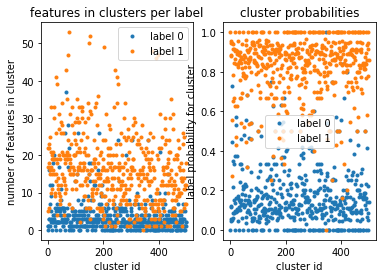

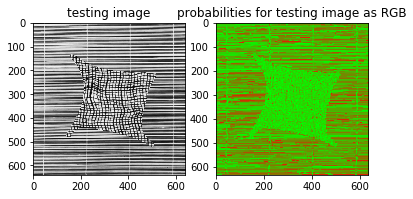

In [122]:
def ind2labels(ind):
    """ Helper function for transforming uint8 image into labeled image."""
    return np.unique(ind, return_inverse=True)[1].reshape(ind.shape)

path = './data/2labels/'

patch_size = 7

# TRAING THE MODEL
training_image = skimage.io.imread(path + 'training_image.png')
training_image = training_image.astype(np.float)
training_labels = skimage.io.imread(path + 'training_labels.png')

training_labels = ind2labels(training_labels)
nr_labels = np.max(training_labels)+1 # number of labels in the training image

fig, ax = plt.subplots(1,2)
ax[0].imshow(training_image, cmap=plt.cm.gray)
ax[0].set_title('training image')
ax[1].imshow(training_labels)
ax[1].set_title('labels for training image')

#%%
features = im2col(training_image, patch_size=[patch_size, patch_size]).T
labels = training_labels.ravel()

nr_keep = 10000 # number of features randomly picked for clustering 
keep_indices = np.random.permutation(np.arange(features.shape[0]))[:nr_keep]

features_subset = features[keep_indices,:]
labels_subset = labels[keep_indices]

nr_clusters = 500 # number of feature clusters
#kmeans = MiniBatchKMeans(n_clusters=100) # normal k-means, for speed I use mini-batches
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=nr_clusters, batch_size=2*nr_clusters)
kmeans.fit(features_subset)
assignment = kmeans.labels_

edges = np.arange(nr_clusters+1)-0.5 # histogram edges halfway between integers
hist = np.zeros((nr_clusters,nr_labels))
for l in range(nr_labels):
    hist[:,l] = np.histogram(assignment[labels_subset==l],bins=edges)[0]
sum_hist = np.sum(hist,axis=1)
cluster_probabilities = hist/(sum_hist.reshape(-1,1))

fig, ax = plt.subplots(1,2)
legend_label = [f'label {x}' for x in range(nr_labels)]

ax[0].plot(hist,'.')
ax[0].set_xlabel('cluster id')
ax[0].set_ylabel('number of features in cluster')
ax[0].legend(legend_label)
ax[0].set_title('features in clusters per label')
ax[1].plot(cluster_probabilities,'.')
ax[1].set_xlabel('cluster id')
ax[1].set_ylabel('label probability for cluster')
ax[1].legend(legend_label)
ax[1].set_title('cluster probabilities')

# Finished training

#%% USING THE MODEL
testing_image = skimage.io.imread(path + 'testing_image.png')
testing_image = testing_image.astype(np.float)

#features_testing = get_gauss_feat_im(testing_image,sigma)
#features_testing = features_testing.reshape(-1, features_testing.shape[2])
features_testing = im2col(testing_image, patch_size=[patch_size, patch_size]).T
assignment_testing = kmeans.predict(features_testing)

probability_image = np.zeros((assignment_testing.size, nr_labels))
for l in range(nr_labels):
    probability_image[:,l] = cluster_probabilities[assignment_testing, l]
    
prob_image_dim_0 = testing_image.shape[0] - (patch_size - 1)
prob_image_dim_1 = testing_image.shape[1] - (patch_size - 1)
probability_image = probability_image.reshape((prob_image_dim_0, prob_image_dim_1) + (nr_labels,))
print(probability_image.shape)

P_rgb = np.zeros(probability_image.shape[0:2]+(3,))
k = min(nr_labels,3)
P_rgb[:,:,:k] = probability_image[:,:,:k]

fig, ax = plt.subplots(1,2)
ax[0].imshow(testing_image, cmap=plt.cm.gray)
ax[0].set_title('testing image')
ax[1].imshow(P_rgb)
ax[1].set_title('probabilities for testing image as RGB')

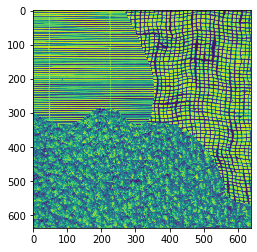

In [92]:
plt.imshow(f[1,:].reshape((638, 638)))

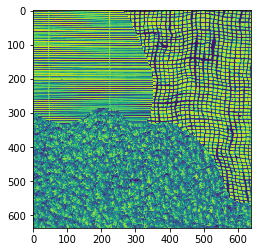

In [108]:
plt.imshow(f.T[:,8].reshape((638, 638)))